In [1]:
import time 
import datetime 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import linregress
import requests
import yfinance as yf

# Making DataFrames with Yahoo finance stock data

In [2]:
tickers = ["UAL", "DAL", "AAL", "LUV"]

# Create an empty list to store the dataframes
dataframes = []

# Get data using yahoo finance for the tickers
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    df = pd.DataFrame(ticker_data.get_shares_full(start='2000-01-01', end='2022-12-31'))
    df.reset_index(inplace=True)
    df['Ticker'] = ticker
    dataframes.append(df)

# Concatenate all dataframes
stock_df = pd.concat(dataframes)

# Change the index column (date) to an actual date
stock_df['index'] = stock_df['index'].dt.strftime('%Y-%m-%d')

# Have to rename som columns...
stock_df.rename(columns={0:'Outstanding Shares','index':'Date'}, inplace = True)
stock_df.head()

,Date,Outstanding Shares,Ticker
0,2015-10-22,372810000,UAL
1,2016-02-19,359485000,UAL
2,2016-04-22,336823000,UAL
3,2016-07-19,322408000,UAL
4,2016-07-19,317286000,UAL


In [3]:
# Initialize a list of tickers for the stock
stock_names = ['United Airilnes', 'Delta Airlines','American Airlines','SouthWest Airlines']

# Define the variables
# We wil use 2015 in this one so we can fill forward later
precovid_date = int(time.mktime(datetime.datetime(2015, 1, 5, 23, 59).timetuple()))
postcovid_date = int(time.mktime(datetime.datetime(2023, 1, 1, 23, 59).timetuple()))
interval = "1wk"

# Initialize an empty list to store the dataframes for each stock
dfs = []

# Repeat a data fetch, this time from a query string
for ticker in tickers:
    query_string = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={precovid_date}&period2={postcovid_date}&interval={interval}&events=history&includeAdjustedClose=true"
    df = pd.read_csv(query_string)
    df['Ticker'] = ticker
    dfs.append(df)

# Concatenate all the dataframes in the dfs list based on the common "Date" column
combined_df = pd.concat(dfs)

# Rearrange columns with "Ticker" as the first column
combined_df = combined_df[['Ticker'] + [col for col in combined_df.columns if col != 'Ticker']]

combined_df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,UAL,2015-01-05,66.629997,67.519997,63.110001,65.339996,65.339996,21566500.0
1,UAL,2015-01-12,66.160004,68.260002,62.369999,65.750000,65.750000,32651700.0
2,UAL,2015-01-19,67.110001,73.220001,65.849998,73.099998,73.099998,30047300.0
3,UAL,2015-01-26,72.540001,74.519997,68.260002,69.370003,69.370003,28651400.0
4,UAL,2015-02-02,69.080002,72.230003,65.739998,67.580002,67.580002,36767600.0
...,...,...,...,...,...,...,...,...
413,LUV,2022-12-05,39.520000,40.380001,37.150002,38.009998,37.415672,30727800.0
414,LUV,2022-12-12,37.919998,39.900002,36.750000,37.279999,36.697083,31697900.0
415,LUV,2022-12-19,37.380001,37.590000,35.090000,36.090000,35.525688,19944600.0
416,LUV,2022-12-26,34.610001,34.880001,32.189999,33.669998,33.143528,53601500.0


In [4]:
# Merging the dataframes by date
merged_df = pd.merge(combined_df, stock_df, on =['Ticker','Date'], how = 'left')

# Need to set an initial values for the shares of United because data does not go back far enough.
# Data is later cut at 2016 so the 2015 error data won't matter
merged_df.at[0, 'Outstanding Shares'] = 372810000

# Fill the NaN values forward using the ffill method
merged_df['Outstanding Shares'].fillna(method='ffill', inplace = True)

# Create the Market Cap column
merged_df['Market Cap'] = merged_df['Close']*merged_df['Outstanding Shares']
merged_df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Outstanding Shares,Market Cap
0,UAL,2015-01-05,66.629997,67.519997,63.110001,65.339996,65.339996,21566500.0,372810000.0,2.435940e+10
1,UAL,2015-01-12,66.160004,68.260002,62.369999,65.750000,65.750000,32651700.0,372810000.0,2.451226e+10
2,UAL,2015-01-19,67.110001,73.220001,65.849998,73.099998,73.099998,30047300.0,372810000.0,2.725241e+10
3,UAL,2015-01-26,72.540001,74.519997,68.260002,69.370003,69.370003,28651400.0,372810000.0,2.586183e+10
4,UAL,2015-02-02,69.080002,72.230003,65.739998,67.580002,67.580002,36767600.0,372810000.0,2.519450e+10
...,...,...,...,...,...,...,...,...,...,...
1668,LUV,2022-12-05,39.520000,40.380001,37.150002,38.009998,37.415672,30727800.0,592342016.0,2.251492e+10
1669,LUV,2022-12-12,37.919998,39.900002,36.750000,37.279999,36.697083,31697900.0,592342016.0,2.208251e+10
1670,LUV,2022-12-19,37.380001,37.590000,35.090000,36.090000,35.525688,19944600.0,592342016.0,2.137762e+10
1671,LUV,2022-12-26,34.610001,34.880001,32.189999,33.669998,33.143528,53601500.0,592342016.0,1.994415e+10


In [5]:
# Now we need to filter the data frame to be 2016 and beyond
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
filtered_df=merged_df[merged_df['Date'].dt.year >= 2016]
filtered_df['Date Numeric'] = pd.to_numeric(filtered_df['Date'])
filtered_df.head()

# Check for any false values to ensure we have clean data
# print(filtered_df['Outstanding Shares'].isna().any())... it works

/var/folders/_n/gpp7329j4799_lfrftrdf3cc0000gn/T/ipykernel_12182/2001657121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date Numeric'] = pd.to_numeric(filtered_df['Date'])


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Outstanding Shares,Market Cap,Date Numeric
52,UAL,2016-01-04,55.790001,56.340000,51.759998,51.889999,51.889999,30039400.0,372810000.0,1.934511e+10,1451865600000000000
53,UAL,2016-01-11,52.200001,52.549999,44.930000,45.669998,45.669998,47275300.0,372810000.0,1.702623e+10,1452470400000000000
54,UAL,2016-01-18,46.509998,47.730000,42.169998,46.720001,46.720001,38951700.0,372810000.0,1.741768e+10,1453075200000000000
55,UAL,2016-01-25,46.910000,49.410000,45.270000,48.279999,48.279999,36135600.0,372810000.0,1.799927e+10,1453680000000000000
56,UAL,2016-02-01,47.709999,49.200001,45.049999,46.860001,46.860001,31200200.0,372810000.0,1.746988e+10,1454284800000000000


In [6]:
#Save combined_df as csv 
FilePath = "outsource_data.csv"
filtered_df.to_csv(FilePath)

# Linear Regression Scatter Plots on Tickers PreCovid

In [7]:
#Define a function for making scatter plot pre-cvoid
def precovid(x_values, y_values, ticker, title=''):
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)

    regress_values = x_values * slope + intercept

    plt.scatter(x_values, y_values, alpha=0.3)
    plt.grid(which='both', axis='both')

    plt.plot(x_values, regress_values, color='r')

    plt.annotate(f"y={slope: .2f}x + {intercept: .2f}", (0,10), color='r')
    
    plt.xticks([])
    
    plt.xlabel('2016 to March 2020')
    plt.ylabel('Volume')
    plt.title(title)

    plt.savefig(f"output_data/PreCovid_{ticker}.png")
    plt.show()
    
    print(f"The r-value is: {r_value}")

In [8]:
#Define a function for making scatter plot post-covid
def postcovid(x_values, y_values, ticker, title=''):
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)

    regress_values = x_values * slope + intercept

    plt.scatter(x_values, y_values, alpha=0.3)
    plt.grid(which='both', axis='both')

    plt.plot(x_values, regress_values, color='r')

    plt.annotate(f"y={slope: .2f}x + {intercept: .2f}", (0,10), color='r')
    
    plt.xticks([])
    
    plt.xlabel('June 2020 to Present')
    plt.ylabel('Market Cap in 10s Billions')
    plt.title(title)
    
    plt.savefig(f"output_data/PostCovid_{ticker}.png")
    plt.show()
    
    print(f"The r-value is: {r_value}")

In [9]:
#Define dataframes for pre/post covid per ticker

# Precovid - the federal government defines the beginning of the crash to be March 9, 2020
precovid_luv = filtered_df[(filtered_df['Ticker'] == 'LUV') & (filtered_df['Date'] <= pd.to_datetime('2020-03-09'))]
precovid_dal = filtered_df[(filtered_df['Ticker'] == 'DAL') & (filtered_df['Date'] <= pd.to_datetime('2020-03-09'))]
precovid_aal = filtered_df[(filtered_df['Ticker'] == 'AAL') & (filtered_df['Date'] <= pd.to_datetime('2020-03-09'))]
precovid_ual = filtered_df[(filtered_df['Ticker'] == 'UAL') & (filtered_df['Date'] <= pd.to_datetime('2020-03-09'))]

# Postcovid - the federal government defines the end of the crash to be April 7, 2020
postcovid_luv = filtered_df[(filtered_df['Ticker'] == 'LUV') & (filtered_df['Date'] >= pd.to_datetime('2020-04-07'))]
postcovid_dal = filtered_df[(filtered_df['Ticker'] == 'DAL') & (filtered_df['Date'] >= pd.to_datetime('2020-04-07'))]
postcovid_aal = filtered_df[(filtered_df['Ticker'] == 'AAL') & (filtered_df['Date'] >= pd.to_datetime('2020-04-07'))]
postcovid_ual = filtered_df[(filtered_df['Ticker'] == 'UAL') & (filtered_df['Date'] >= pd.to_datetime('2020-04-07'))]

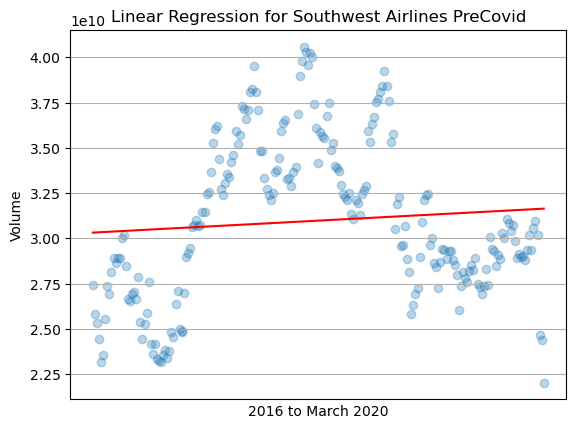

The r-value is: 0.08865229109367524


In [10]:
precovid(precovid_luv['Date Numeric'], precovid_luv['Market Cap'], \
         "Luv", title='Linear Regression for Southwest Airlines PreCovid')

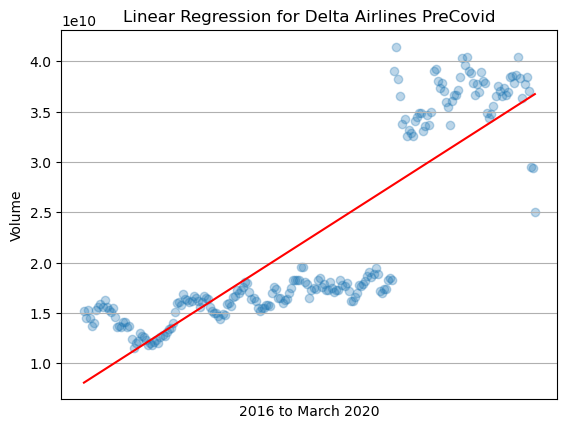

The r-value is: 0.8563226620021871


In [11]:
precovid(precovid_dal['Date Numeric'], precovid_dal['Market Cap'], \
         "Luv", title='Linear Regression for Delta Airlines PreCovid')

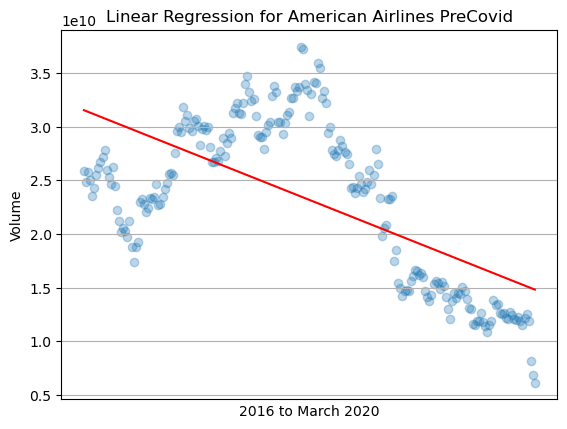

The r-value is: -0.6412405956289015


In [12]:
precovid(precovid_aal['Date Numeric'], precovid_aal['Market Cap'], \
         "AAL", title='Linear Regression for American Airlines PreCovid')

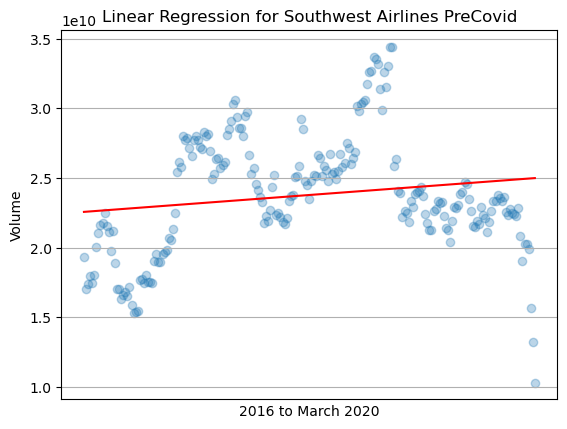

The r-value is: 0.16543829705724217


In [13]:
precovid(precovid_ual['Date Numeric'], precovid_ual['Market Cap'], \
         "UAL", title='Linear Regression for Southwest Airlines PreCovid')

# Linear Regression Scatter Plots on Tickers Post Covid

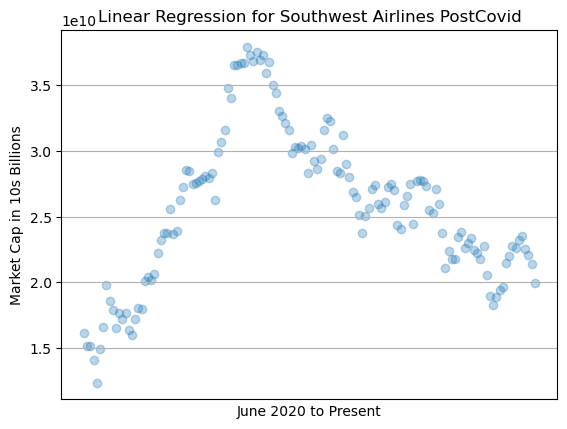

The r-value is: nan


In [14]:
postcovid(postcovid_luv['Date Numeric'], postcovid_luv['Market Cap'], \
         "Luv", title='Linear Regression for Southwest Airlines PostCovid')

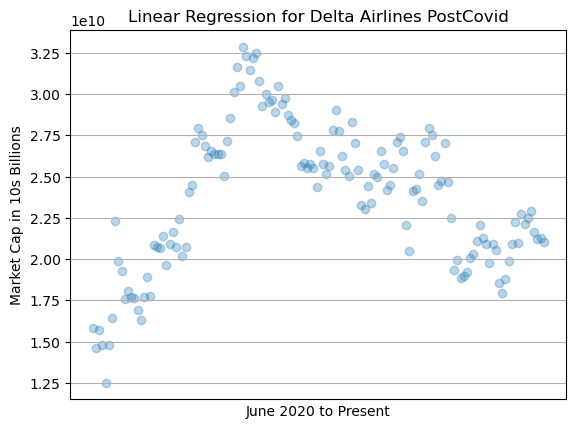

The r-value is: nan


In [15]:
postcovid(postcovid_dal['Date Numeric'], postcovid_dal['Market Cap'], \
         "DAL", title='Linear Regression for Delta Airlines PostCovid')

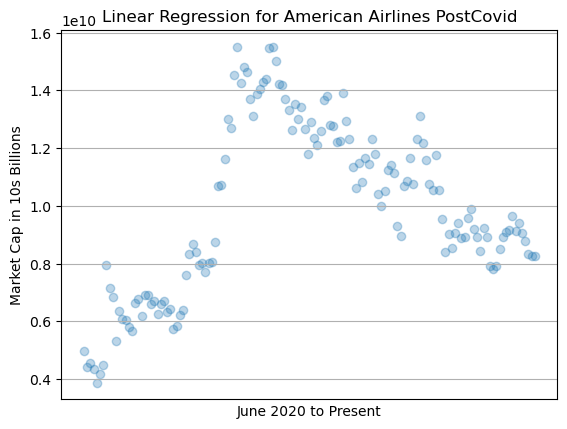

The r-value is: nan


In [16]:
postcovid(postcovid_aal['Date Numeric'], postcovid_aal['Market Cap'], \
         "AAL", title='Linear Regression for American Airlines PostCovid')

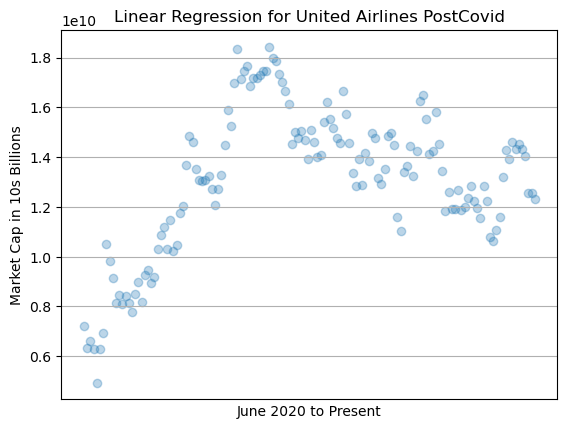

The r-value is: nan


In [17]:
postcovid(postcovid_ual['Date Numeric'], postcovid_ual['Market Cap'], \
         "UAL", title='Linear Regression for United Airlines PostCovid')

# Total Market Cap Growth (Initial Graph)

In [18]:
mkt_cap = filtered_df.groupby(['Date']).sum(['Market Cap'])
mkt_cap

,Open,High,Low,Close,Adj Close,Volume,Outstanding Shares,Market Cap,Date Numeric
Date,,,,,,,,,
2016-01-04,188.200001,191.290001,179.110000,181.079998,172.446342,182080300.0,1.990258e+09,8.787548e+10,5807462400000000000
2016-01-11,182.050003,185.770001,165.590000,168.699996,160.478938,217010700.0,1.990258e+09,8.225004e+10,5809881600000000000
2016-01-18,172.569995,177.440003,158.049999,172.639999,164.192153,181490200.0,1.990258e+09,8.377747e+10,5812300800000000000
2016-01-25,173.869998,177.279999,159.799994,169.180001,161.095844,200528100.0,1.990258e+09,8.190548e+10,5814720000000000000
2016-02-01,169.059998,173.310002,157.989993,161.309998,153.651951,174216500.0,1.990258e+09,7.794128e+10,5817139200000000000
...,...,...,...,...,...,...,...,...,...
2022-12-05,133.570000,137.570003,125.900001,128.379998,127.714826,238878600.0,2.209790e+09,6.703811e+10,6680793600000000000
2022-12-12,128.099997,135.930003,119.799999,121.630000,120.977687,322577200.0,2.209790e+09,6.418934e+10,6683212800000000000
2022-12-19,122.210000,124.240001,116.779999,120.349999,119.716183,198379300.0,2.209790e+09,6.343849e+10,6685632000000000000


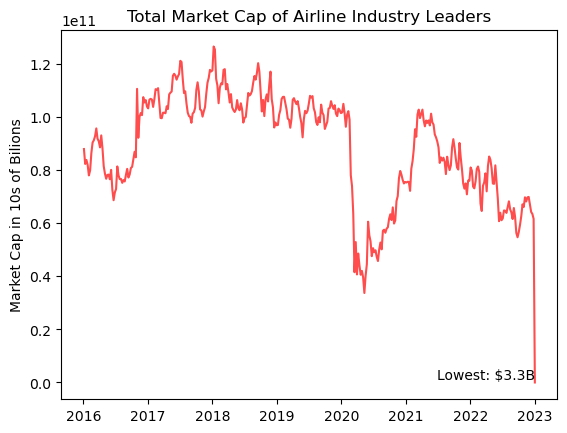

In [19]:
# Make a line chart
# Later to do... adjust the y axis to be in billions not 10 of billions
lowest_index = mkt_cap['Market Cap'].idxmin()
lowest_value = mkt_cap['Market Cap'].min()

plt.plot(mkt_cap.index, mkt_cap['Market Cap'], linestyle='-', color='r', alpha = 0.7)
plt.text(lowest_index, lowest_value, f'Lowest: $3.3B', ha='right', va='bottom', fontsize=10)
plt.ylabel('Market Cap in 10s of Bilions')
plt.title('Total Market Cap of Airline Industry Leaders')
plt.savefig(f"output_data/MktCapGrowth.png")
plt.show()

# Stacked Line Chart for Market Cap

In [20]:
# Change filter to year
filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
# Add a year column
filtered_df['Year'] = filtered_df['Date'].dt.year
# Stackoverflow told me this is how to get the end of the year values
market_cap_end_of_year = filtered_df.groupby(['Ticker', 'Year']).tail(1)
print(market_cap_end_of_year[['Ticker', 'Date', 'Market Cap']])

     Ticker       Date    Market Cap
103     UAL 2016-12-26  2.717039e+10
155     UAL 2017-12-25  2.512739e+10
208     UAL 2018-12-31  2.252732e+10
260     UAL 2019-12-30  2.239798e+10
312     UAL 2020-12-28  1.305653e+10
364     UAL 2021-12-27  1.383282e+10
416     UAL 2022-12-26  1.231829e+10
417     UAL 2023-01-02           NaN
521     DAL 2016-12-26  1.607259e+10
573     DAL 2017-12-25  1.829772e+10
626     DAL 2018-12-31  3.264153e+10
678     DAL 2019-12-30  3.787353e+10
730     DAL 2020-12-28  2.652296e+10
782     DAL 2021-12-27  2.499795e+10
834     DAL 2022-12-26  2.106944e+10
835     DAL 2023-01-02           NaN
939     AAL 2016-12-26  2.993707e+10
991     AAL 2017-12-25  3.336101e+10
1044    AAL 2018-12-31  1.475702e+10
1096    AAL 2019-12-30  1.211230e+10
1148    AAL 2020-12-28  8.020007e+09
1200    AAL 2021-12-27  1.146451e+10
1252    AAL 2022-12-26  8.261831e+09
1253    AAL 2023-01-02           NaN
1358    LUV 2016-12-26  3.066431e+10
1410    LUV 2017-12-25  4.026844e+10
1

/var/folders/_n/gpp7329j4799_lfrftrdf3cc0000gn/T/ipykernel_12182/3417551632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
/var/folders/_n/gpp7329j4799_lfrftrdf3cc0000gn/T/ipykernel_12182/3417551632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['Date'].dt.year


In [21]:
# Creating the data for the line graph. Ripped off the data frame above
data = {
    'Ticker': ['UAL', 'UAL', 'UAL', 'UAL', 'UAL', 
               'UAL', 'UAL', 'DAL', 'DAL', 'DAL', 
               'DAL', 'DAL', 'DAL', 'DAL', 'AAL', 'AAL', 
               'AAL', 'AAL', 'AAL', 'AAL', 'AAL', 'LUV', 
               'LUV', 'LUV', 'LUV', 'LUV', 'LUV', 'LUV'],
    'Date': ['2016-12-29', '2017-12-28', '2018-12-27', 
             '2019-12-26', '2020-12-31', '2021-12-30', 
             '2022-12-29', '2016-12-29', '2017-12-28', 
             '2018-12-27', '2019-12-26', '2020-12-31', 
             '2021-12-30', '2022-12-29', '2016-12-29', 
             '2017-12-28', '2018-12-27', '2019-12-26', 
             '2020-12-31', '2021-12-30', '2022-12-29', 
             '2016-12-29', '2017-12-28', '2018-12-27', 
             '2019-12-26', '2020-12-31', '2021-12-30', 
             '2022-12-29'],
    'Market Cap': [2.722259e+10, 2.154853e+10, 2.293602e+10, 
                   2.229064e+10, 1.274250e+10, 1.603829e+10, 
                   1.231768e+10, 3.901984e+10, 4.095810e+10, 
                   3.421247e+10, 3.782153e+10, 2.611548e+10, 
                   2.577578e+10, 2.102810e+10, 2.419644e+10, 
                   2.549005e+10, 1.495967e+10, 1.256350e+10, 
                   9.389445e+09, 1.198087e+10, 8.266041e+09, 
                   3.181795e+10, 4.025933e+10, 2.650715e+10, 
                   2.801432e+10, 2.759526e+10, 2.603856e+10, 
                   2.007483e+10]
}

# Make dataframe
stacked = pd.DataFrame(data)

# Convert date to actual date
stacked['Date'] = pd.to_datetime(stacked['Date'])

stacked

,Ticker,Date,Market Cap
0,UAL,2016-12-29,2.722259e+10
1,UAL,2017-12-28,2.154853e+10
2,UAL,2018-12-27,2.293602e+10
3,UAL,2019-12-26,2.229064e+10
4,UAL,2020-12-31,1.274250e+10
5,UAL,2021-12-30,1.603829e+10
6,UAL,2022-12-29,1.231768e+10
7,DAL,2016-12-29,3.901984e+10
8,DAL,2017-12-28,4.095810e+10
9,DAL,2018-12-27,3.421247e+10


In [22]:
# Pivot the DataFrame to have Tickers as columns and Dates as the index
# This basically makes a pivot table in python with the data that we have.
stacked_piv = stacked.pivot(index='Date', columns='Ticker', values='Market Cap')
stacked_piv

Ticker,AAL,DAL,LUV,UAL
Date,,,,
2016-12-29,2.419644e+10,3.901984e+10,3.181795e+10,2.722259e+10
2017-12-28,2.549005e+10,4.095810e+10,4.025933e+10,2.154853e+10
2018-12-27,1.495967e+10,3.421247e+10,2.650715e+10,2.293602e+10
2019-12-26,1.256350e+10,3.782153e+10,2.801432e+10,2.229064e+10
2020-12-31,9.389445e+09,2.611548e+10,2.759526e+10,1.274250e+10
2021-12-30,1.198087e+10,2.577578e+10,2.603856e+10,1.603829e+10
2022-12-29,8.266041e+09,2.102810e+10,2.007483e+10,1.231768e+10


In [23]:
# We now need a total so we can do percentages
stacked_piv['Total'] = stacked_piv.sum(axis=1)
stacked_piv

Ticker,AAL,DAL,LUV,UAL,Total
Date,,,,,
2016-12-29,2.419644e+10,3.901984e+10,3.181795e+10,2.722259e+10,1.222568e+11
2017-12-28,2.549005e+10,4.095810e+10,4.025933e+10,2.154853e+10,1.282560e+11
2018-12-27,1.495967e+10,3.421247e+10,2.650715e+10,2.293602e+10,9.861531e+10
2019-12-26,1.256350e+10,3.782153e+10,2.801432e+10,2.229064e+10,1.006900e+11
2020-12-31,9.389445e+09,2.611548e+10,2.759526e+10,1.274250e+10,7.584268e+10
2021-12-30,1.198087e+10,2.577578e+10,2.603856e+10,1.603829e+10,7.983350e+10
2022-12-29,8.266041e+09,2.102810e+10,2.007483e+10,1.231768e+10,6.168665e+10


In [24]:
# Some cheeky code to convert everything to percentages
for column in stacked_piv.columns:
    if column != 'Total':
        stacked_piv[column] = stacked_piv[column] / stacked_piv['Total'] * 100

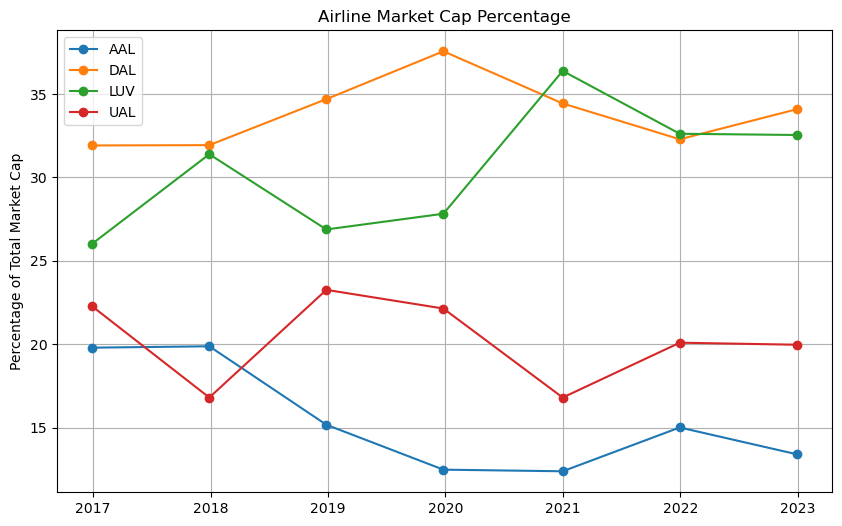

In [25]:
plt.figure(figsize=(10, 6))

# We need to exclude the total column at the end.
for column in stacked_piv.columns[:-1]:
    plt.plot(stacked_piv.index, stacked_piv[column], marker='o', label=column)

plt.ylabel('Percentage of Total Market Cap')
plt.title('Airline Market Cap Percentage')
plt.legend()
plt.grid(True)
plt.savefig(f"output_data/StackedLineChart.png")
plt.show()


# Pie Charts

In [26]:
nineteen_row = stacked_piv.iloc[3]
nineteen = pd.DataFrame(nineteen_row)
nineteen = nineteen.drop(index='Total')
print(nineteen)

twentytwo_row = stacked_piv.iloc[6]
twentytwo = pd.DataFrame(twentytwo_row)
twentytwo = twentytwo.drop(index='Total')
print(twentytwo)

        2019-12-26
Ticker            
AAL      12.477407
DAL      37.562354
LUV      27.822349
UAL      22.137891
        2022-12-29
Ticker            
AAL      13.400048
DAL      34.088575
LUV      32.543232
UAL      19.968145


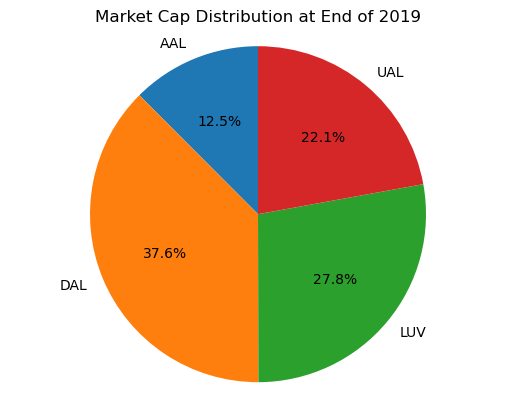

In [27]:
# Plotting the pie chart for 2019
nineteen['2019-12-26'].plot.pie(autopct='%1.1f%%', startangle = 90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.title('Market Cap Distribution at End of 2019')
plt.ylabel('')  # To remove the y-label, as it will show the column name '2019-12-26'.
plt.savefig(f"output_data/PieChart2019.png")
plt.show()

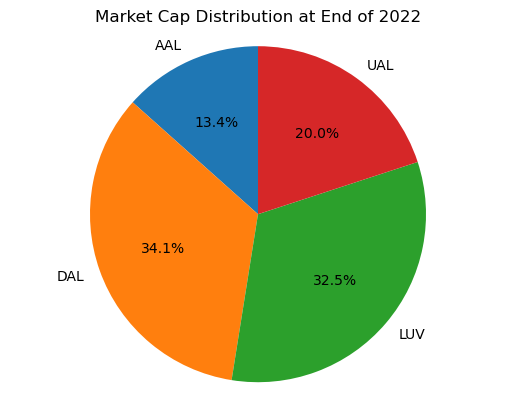

In [28]:
twentytwo['2022-12-29'].plot.pie(autopct='%1.1f%%', startangle = 90)
plt.axis('equal')
plt.title('Market Cap Distribution at End of 2022')
plt.ylabel('')
plt.savefig(f"output_data/PieChart2022.png")
plt.show()

# Double Bar Chart

In [29]:
nt_tt = pd.merge(nineteen, twentytwo, on='Ticker')
nt_tt

,2019-12-26 00:00:00,2022-12-29 00:00:00
Ticker,,
AAL,12.477407,13.400048
DAL,37.562354,34.088575
LUV,27.822349,32.543232
UAL,22.137891,19.968145


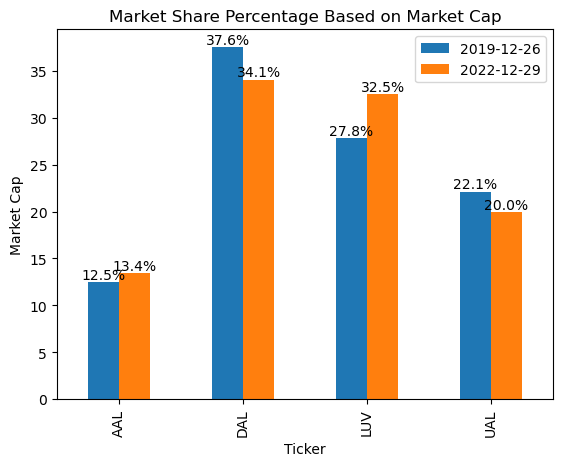

In [30]:
ax = nt_tt.plot(kind='bar', stacked=False)
plt.title('Market Share Percentage Based on Market Cap')
plt.xlabel('Ticker')
plt.ylabel('Market Cap')
plt.legend(['2019-12-26', '2022-12-29'])

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.1f%%')
    
plt.savefig(f"output_data/DoubleBarMktCap.png")

plt.show()

# Market Crash on Black Monday II (March 16)
## Three bad days during the start of Covid, March 9 (Black Monday I), March 12, and March 16th (Black Market II). Here what the overall airline market cap looked like on Market 16th for each year.

In [ ]:
# Filter for March data in the week (market is closed on weekends so we need to adjust a little bit)
march_month = filtered_df[filtered_df['Date'].dt.month == 3]
march_day = march_month[march_month['Date'].dt.day.between(9, 23)]
march_day

In [ ]:
march_market_caps = march_day.groupby('Date')['Market Cap'].sum()
march_market_caps

In [ ]:
data = {
    'Date': ['2016-03-14','2017-03-13','2018-03-12','2019-03-11','2020-03-16','2021-03-15','2022-03-14'],
    'Market Cap': [9.563166e+10,9.956651e+10,1.179388e+11,9.892712e+10,4.149990e+10,1.027119e+11,7.404664e+10]
}
df_march_day = pd.DataFrame(data)
df_march_day

In [ ]:
# Make the bar chart
plt.bar(df_march_day['Date'],df_march_day['Market Cap'])
plt.xticks(rotation=45)
plt.ylabel('Collective Market Cap in 10s of Billions')
plt.title('Collective Market Cap on Nearest Day to March 16 Each Year')
plt.savefig(f"output_data/March16MktCap.png")
plt.show()